Step1:- Importing all the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                           confusion_matrix, roc_auc_score)

Step2:- Loading and processing the dataset

In [2]:
raw_dataset = pd.read_csv(r"D:\gitclone\Winter-Project-Introduction-To-Machine-Learning\IITK\Final Task\Original Mutagenicity Dataset.csv")
cleaned_dataset = raw_dataset.drop(columns=["Unnamed: 0", "Id", "CAS", "SMILES", "Status", "Predicted value"])

Step3:-Initial dataset summary and Initial feature corelation heatmap.


Initial Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Experimental value   5764 non-null   int64  
 1   NumValenceElectrons  5764 non-null   int64  
 2   qed                  5764 non-null   float64
 3   TPSA                 5764 non-null   float64
 4   MolMR                5764 non-null   float64
 5   BalabanJ             5764 non-null   float64
 6   BertzCT              5764 non-null   float64
 7   MolWt                5764 non-null   float64
 8   MolLogP              5764 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 405.4 KB
None 

       Experimental value  NumValenceElectrons          qed         TPSA  \
count         5764.000000          5764.000000  5764.000000  5764.000000   
mean             0.564018            86.975885     0.514007    53.769226   
std              0.495928     

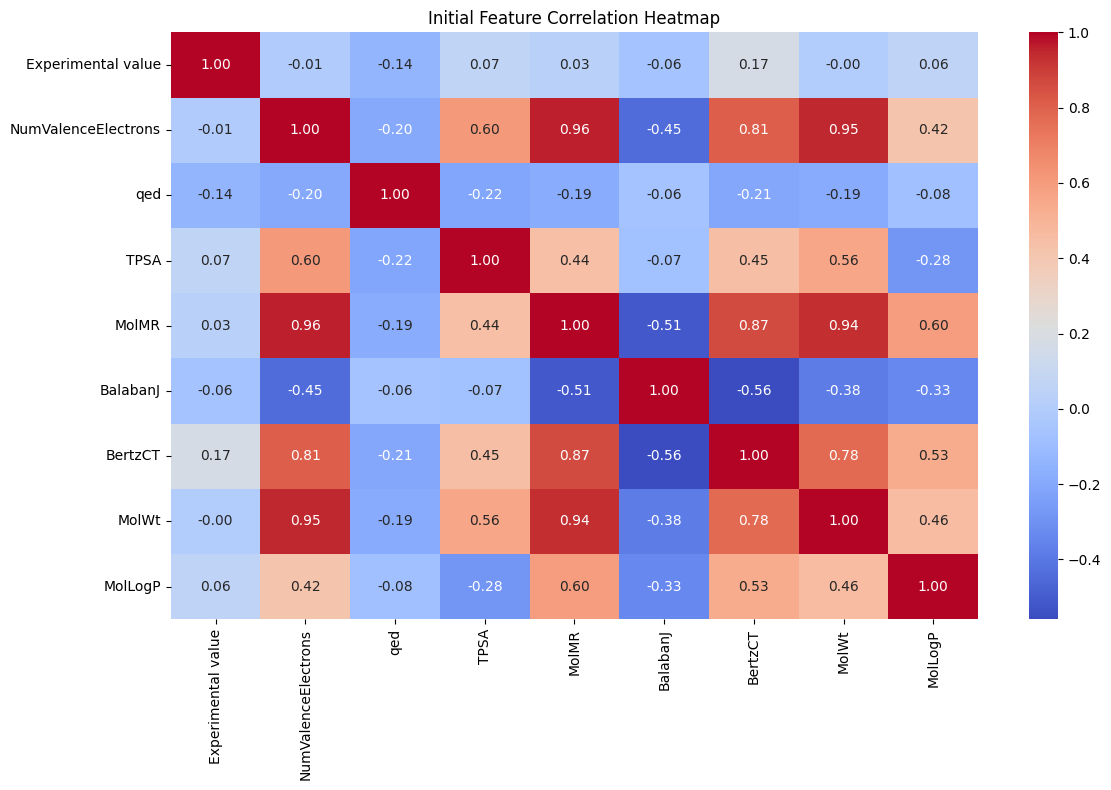

In [3]:
# Initial Dataset Sumary
print("\nInitial Dataset Overview:")
print(cleaned_dataset.info(), "\n")
print(cleaned_dataset.describe())

# Initial Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Initial Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

Step4:-Handling outliners

In [4]:
# Handle outliners with quantile clipping
outlier_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
input_features = cleaned_dataset.drop(columns=["Experimental value"])
normalized_features = pd.DataFrame(outlier_transformer.fit_transform(input_features), columns=input_features.columns)

Step5:-Summary after processing

In [5]:
# Summary
print("\nDataset Summary After Outlier Normalization:")
print(normalized_features.describe())


Dataset Summary After Outlier Normalization:
       NumValenceElectrons          qed         TPSA        MolMR  \
count          5764.000000  5764.000000  5764.000000  5764.000000   
mean              0.000268    -0.000133    -0.265607    -0.000025   
std               1.002541     1.002685     1.672319     1.003022   
min              -5.199338    -5.199338    -5.199338    -5.199338   
25%              -0.644086    -0.674729    -0.684763    -0.674802   
50%               0.012546    -0.000531    -0.001255     0.000397   
75%               0.648724     0.673916     0.674254     0.673882   
max               5.199338     5.199338     5.199338     5.199338   

          BalabanJ      BertzCT        MolWt      MolLogP  
count  5764.000000  5764.000000  5764.000000  5764.000000  
mean     -0.000084    -0.000404    -0.000364     0.000023  
std       1.002627     1.003994     1.003502     1.002196  
min      -5.199338    -5.199338    -5.199338    -5.199338  
25%      -0.674526    -0.674445 

Step6:-Feauture correlation heatmap after processing

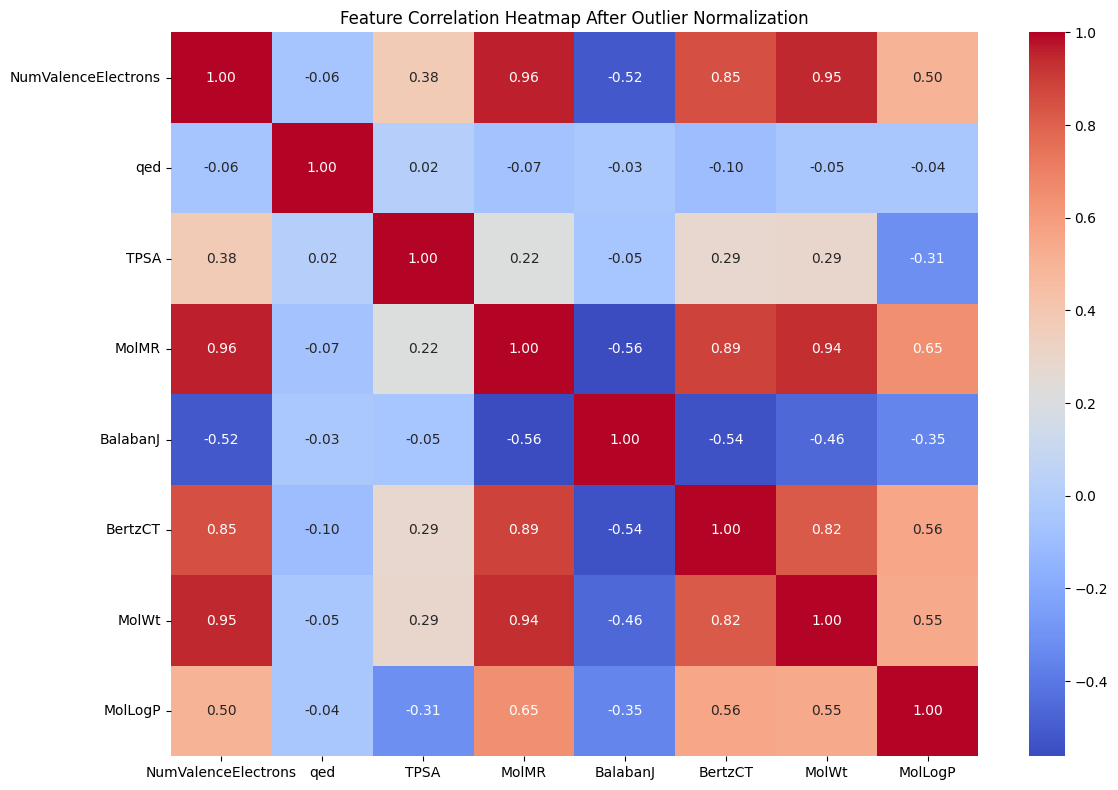

In [6]:
# Feature Correlation Heatmap after processing
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_features.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap After Outlier Normalization")
plt.tight_layout()
plt.show()

Step7:-Feature selection and engineering 

In [7]:
# Feature selection and engineering
# Remove low variance features
variance_selector = VarianceThreshold(threshold=0.01)
variance_filtered_features = variance_selector.fit_transform(normalized_features)

# Select top K features
importance_selector = SelectKBest(mutual_info_classif, k=min(10, variance_filtered_features.shape[1]))
important_features = importance_selector.fit_transform(variance_filtered_features, cleaned_dataset["Experimental value"])

# PCA for dimensionality reduction
dimension_reducer = PCA(n_components=min(5, important_features.shape[1]))
reduced_features = dimension_reducer.fit_transform(important_features)
target_values = np.array(cleaned_dataset["Experimental value"])

# Add bias term
feature_matrix = np.c_[np.ones(reduced_features.shape[0]), reduced_features]

# Train-test split
training_features, testing_features, training_targets, testing_targets = train_test_split(
    feature_matrix, target_values, test_size=0.2, random_state=42, stratify=target_values
)

# Standardize features
feature_scaler = StandardScaler()
training_features_scaled = feature_scaler.fit_transform(training_features)
testing_features_scaled = feature_scaler.transform(testing_features)

# Cross-validation scores vs k-value for KNN
neighbor_counts = range(1, 31)
cross_val_mean_scores = []
cross_val_score_spreads = []

for neighbor_count in neighbor_counts:
    validation_scores = cross_val_score(
        KNeighborsClassifier(n_neighbors=neighbor_count), 
        training_features_scaled, training_targets, 
        cv=5, scoring='f1'
    )
    cross_val_mean_scores.append(validation_scores.mean())
    cross_val_score_spreads.append(validation_scores.std())

optimal_neighbors = neighbor_counts[np.argmax(cross_val_mean_scores)]
print(f"\nOptimal number of neighbors: {optimal_neighbors}")
print(f"Best Cross-Validation F1-score: {max(cross_val_mean_scores):.4f} ± {cross_val_score_spreads[np.argmax(cross_val_mean_scores)]:.4f}")


Optimal number of neighbors: 13
Best Cross-Validation F1-score: 0.7182 ± 0.0110


Step8:-Plot CV scores vs K value

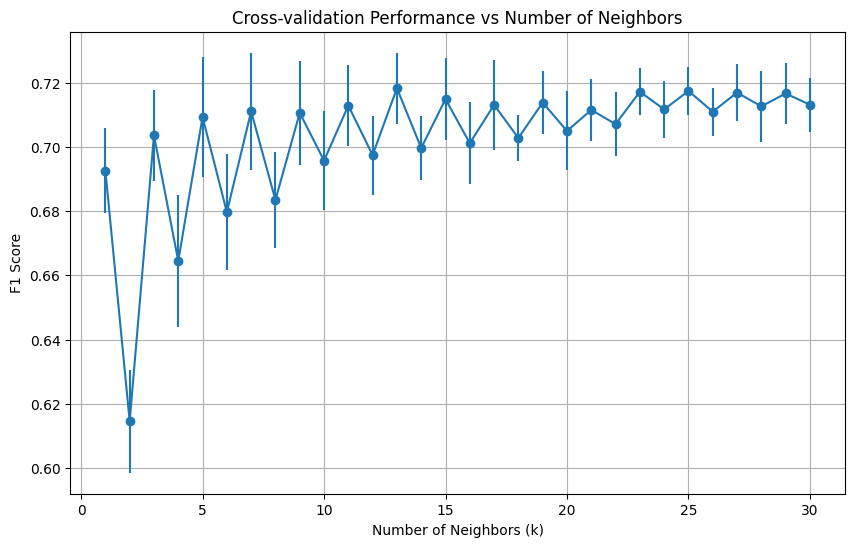

In [8]:
# Plot CV scores vs k-value
plt.figure(figsize=(10, 6))
plt.errorbar(neighbor_counts, cross_val_mean_scores, yerr=cross_val_score_spreads, fmt='o-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('Cross-validation Performance vs Number of Neighbors')
plt.grid(True)
plt.show()

Step9:-Initialize model with optimal neighbours for KNN.And then training and evaluating

In [9]:
# Initialize models with optimal neighbors for KNN
classifier_models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=optimal_neighbors),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

# Train and evaluate models
model_performance = {}
for model_name, classifier in classifier_models.items():
    # Cross-validation
    validation_scores = cross_val_score(classifier, training_features_scaled, training_targets, cv=5, scoring='f1')
    print(f"\n{model_name} Cross-Validation F1-score: {validation_scores.mean():.4f} ± {validation_scores.std():.4f}")
    
    # Train model
    classifier.fit(training_features_scaled, training_targets)
    
    # Make predictions
    predicted_labels = classifier.predict(testing_features_scaled)
    prediction_probabilities = classifier.predict_proba(testing_features_scaled)
    
    # Store performance metrics
    model_performance[model_name] = {
        "F1-score": f1_score(testing_targets, predicted_labels),
        "Accuracy": accuracy_score(testing_targets, predicted_labels),
        "Precision": precision_score(testing_targets, predicted_labels),
        "Recall": recall_score(testing_targets, predicted_labels),
        "ROC AUC": roc_auc_score(testing_targets, prediction_probabilities[:, 1])
    }


K-Nearest Neighbors Cross-Validation F1-score: 0.7182 ± 0.0110

Logistic Regression Cross-Validation F1-score: 0.7018 ± 0.0084

Decision Tree Cross-Validation F1-score: 0.6713 ± 0.0065

Random Forest Cross-Validation F1-score: 0.7251 ± 0.0139

Support Vector Machine Cross-Validation F1-score: 0.7186 ± 0.0168


Step10:-Printing detailed performance metrices

In [10]:
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance Metrics:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")


K-Nearest Neighbors Performance Metrics:
F1-score: 0.7259
Accuracy: 0.6817
Precision: 0.7054
Recall: 0.7477
ROC AUC: 0.7289

Logistic Regression Performance Metrics:
F1-score: 0.6957
Accuracy: 0.6002
Precision: 0.6092
Recall: 0.8108
ROC AUC: 0.6285

Decision Tree Performance Metrics:
F1-score: 0.6708
Accuracy: 0.6349
Precision: 0.6820
Recall: 0.6600
ROC AUC: 0.6312

Random Forest Performance Metrics:
F1-score: 0.7164
Accuracy: 0.6869
Precision: 0.7319
Recall: 0.7015
ROC AUC: 0.7525

Support Vector Machine Performance Metrics:
F1-score: 0.7200
Accuracy: 0.6782
Precision: 0.7067
Recall: 0.7338
ROC AUC: 0.7343


Step11:-Plotting charts. These charts are for some insights.Here is the list of them:-
(i) Model Comparison
(ii) Individual confusion matrices
(iii) Feature Correlation Heatmap for final selected features
(iv) Probability distributions plots for each model


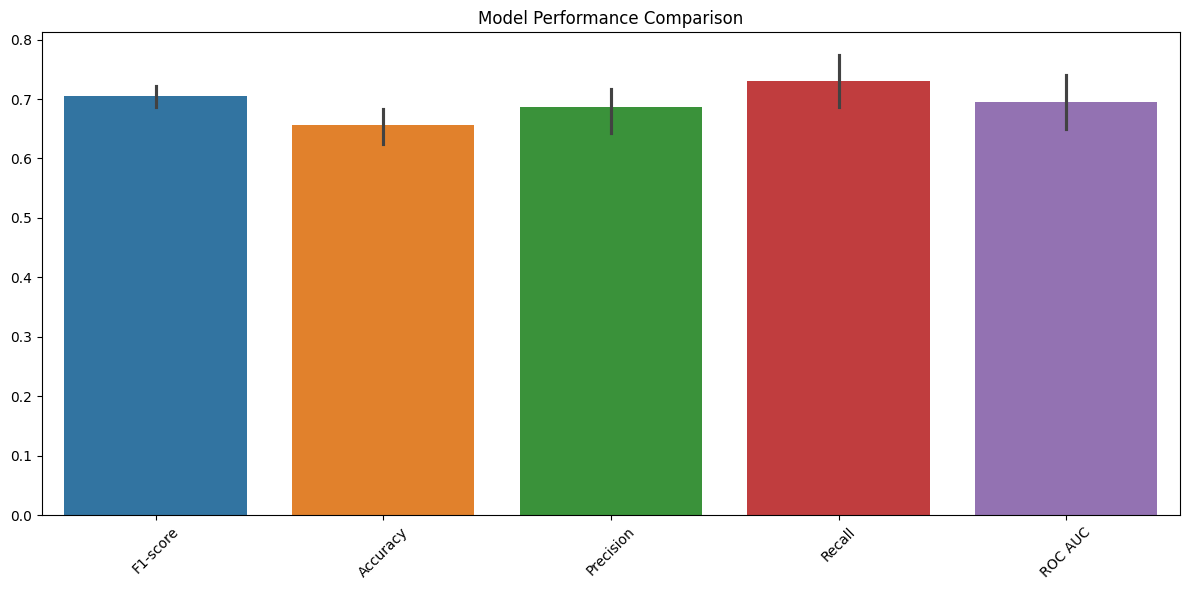

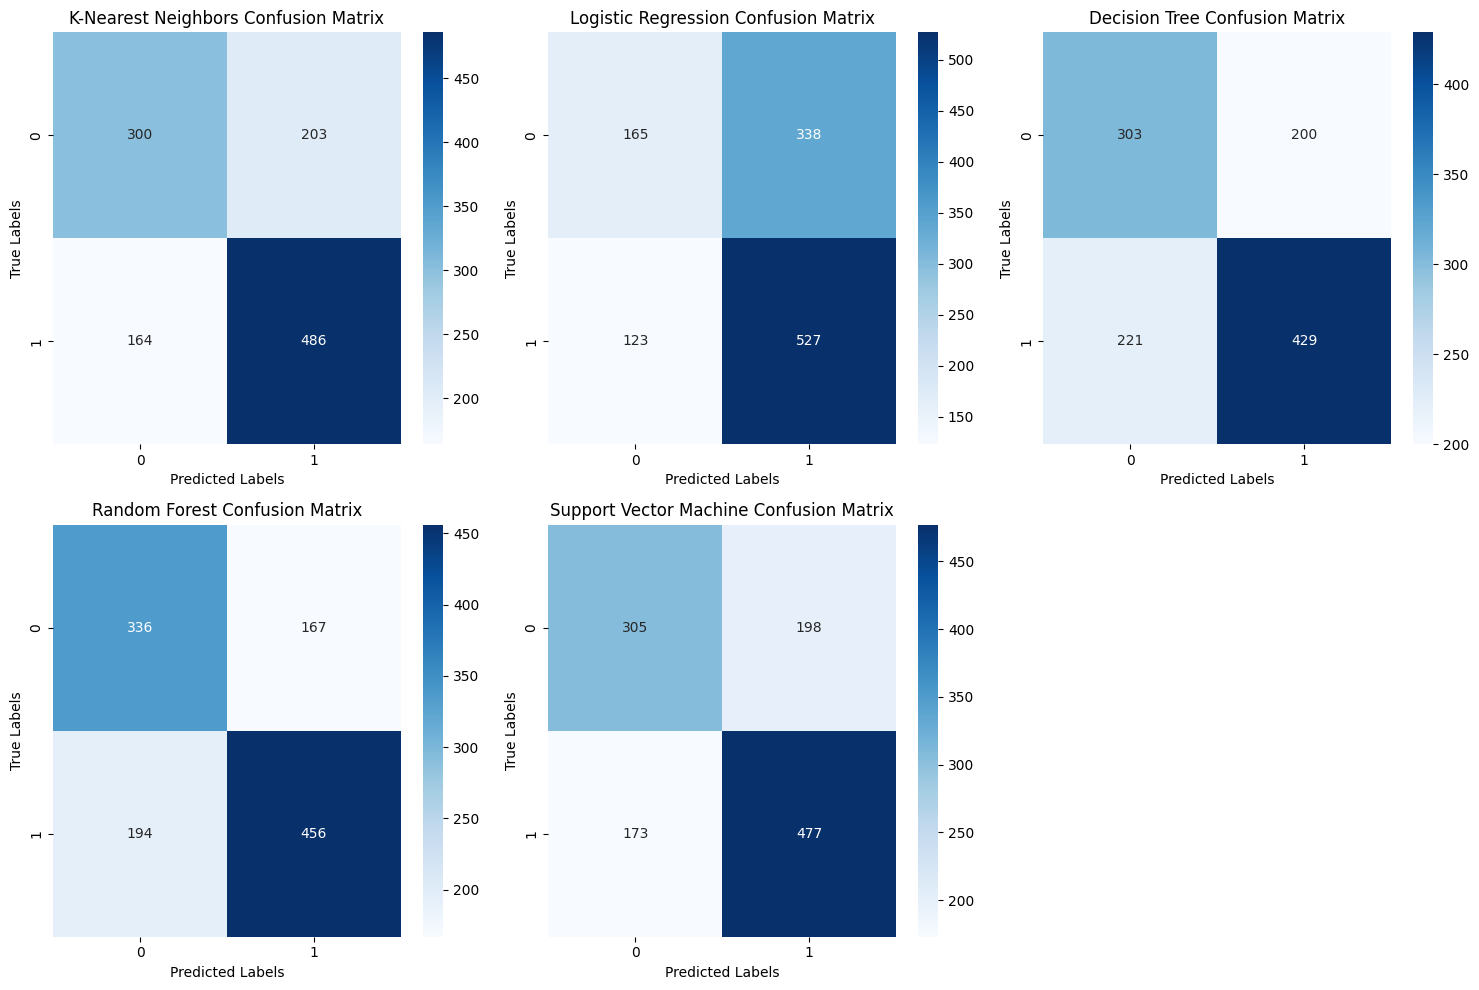

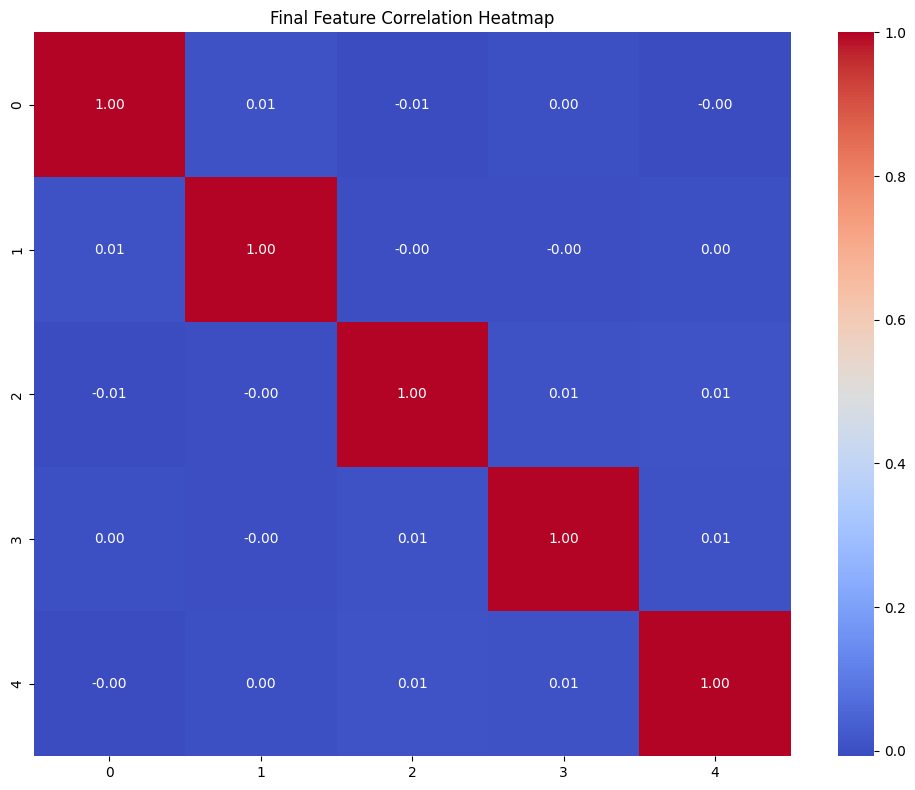

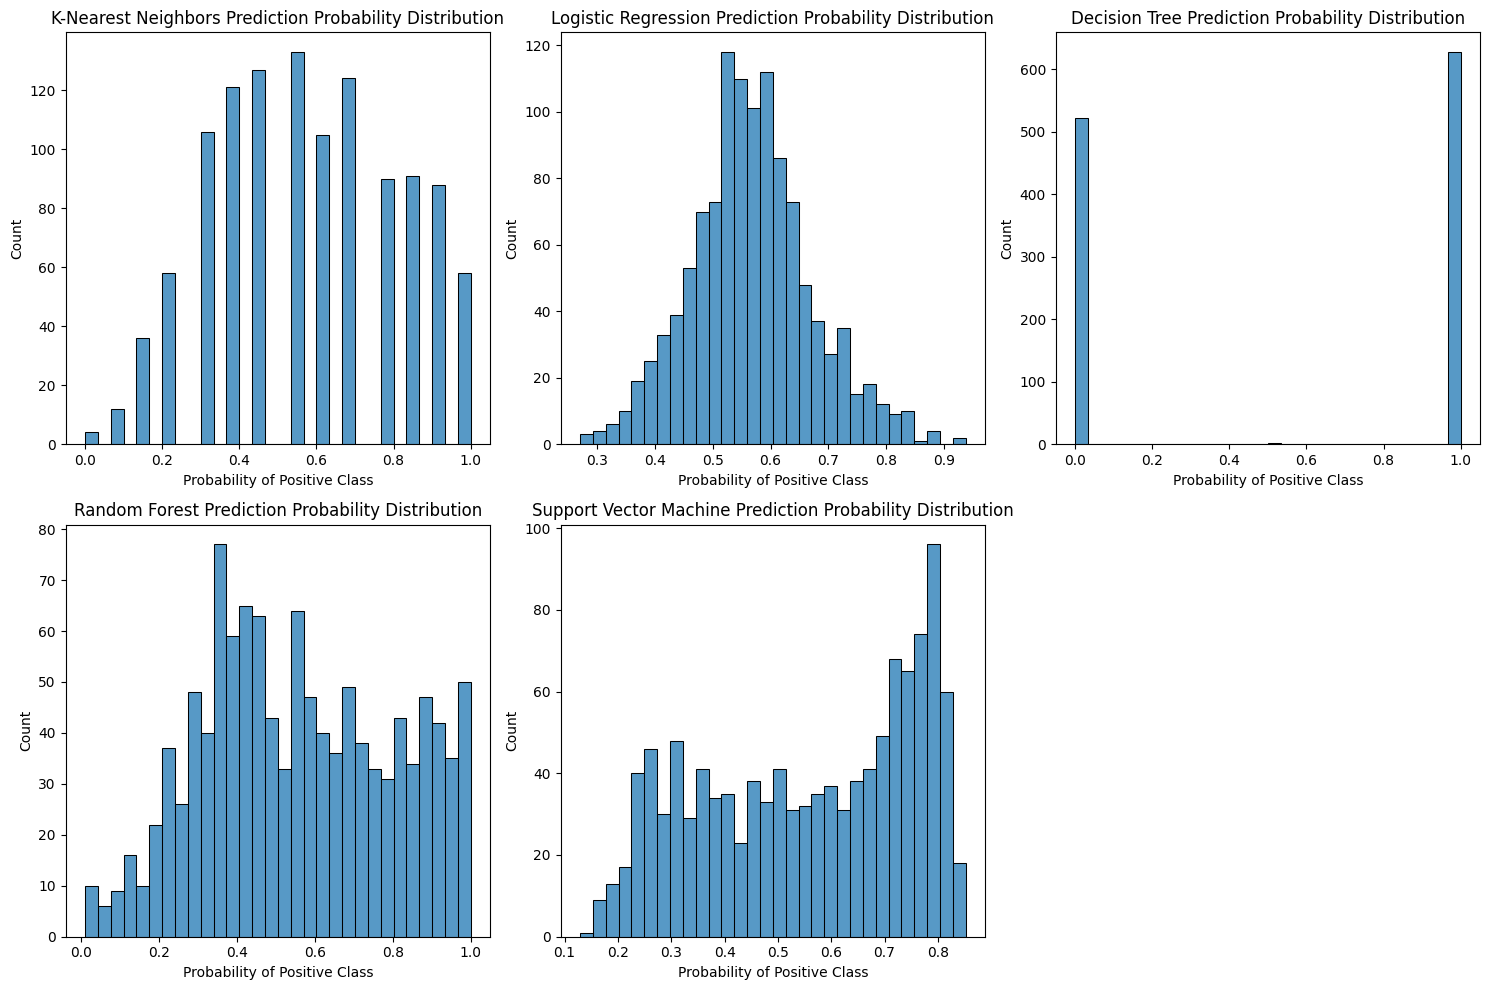

In [11]:
# Plot model comparison
plt.figure(figsize=(12, 6))
performance_comparison = pd.DataFrame(model_performance).T
sns.barplot(data=performance_comparison)
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot individual confusion matrices
plt.figure(figsize=(15, 10))
for idx, (model_name, classifier) in enumerate(classifier_models.items(), 1):
    plt.subplot(2, 3, idx)
    predicted_labels = classifier.predict(testing_features_scaled)
    confusion_mat = confusion_matrix(testing_targets, predicted_labels)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Plot feature correlation heatmap of final selected features
final_feature_correlations = pd.DataFrame(training_features_scaled[:, 1:])  # Exclude bias term
plt.figure(figsize=(10, 8))
sns.heatmap(final_feature_correlations.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Final Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Probability distribution plots for each model
plt.figure(figsize=(15, 10))
for idx, (model_name, classifier) in enumerate(classifier_models.items(), 1):
    plt.subplot(2, 3, idx)
    prediction_probabilities = classifier.predict_proba(testing_features_scaled)[:, 1]
    sns.histplot(prediction_probabilities, bins=30)
    plt.title(f'{model_name} Prediction Probability Distribution')
    plt.xlabel('Probability of Positive Class')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()